In [23]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 30 09:43:46 2024

@author: Admin
"""

import torch
import torch.nn.functional as F
import math

class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.view(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output
        
        output = output.view(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features, grid_size) shape which is extremely
        computational heavy.
        """
        regu_activation = torch.norm(self.spline_weight, p=1)
        regu_entropy = torch.norm(
            torch.log1p(torch.exp(-self.spline_weight.abs() * 2)), p=1
        )

        loss = (
            regu_activation * regularize_activation
            + regu_entropy * regularize_entropy
        )
        return loss

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    @torch.no_grad()
    def update_grid(self, x, margin=0.01):
        for layer in self.layers:
            layer.update_grid(x, margin=margin)

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        loss = sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )
        return loss

# Example usage



In [24]:


import pandas as pd
local='D://a_trash//MSFT.csv'
df_raw=pd.read_csv(local)
#Chuyển đổi cột 'date' thành datetime
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Tạo cột 'month_day' chỉ chứa tháng và ngày
df_raw['year-month-day'] = df_raw['Date'].dt.strftime('%Y-%m-%d')

In [25]:
average_values = df_raw.groupby('year-month-day')[['Open', 'High', 'Low','Close']].mean().reset_index()
df_raw.head(8)

,Date,Open,High,Low,Close,Adj Close,Volume,year-month-day
0,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605301,37130100,2021-01-04
1,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809433,23823000,2021-01-05
2,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700,2021-01-06
3,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188538,27694500,2021-01-07
4,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481339,22956200,2021-01-08
5,2021-01-11,218.470001,218.910004,216.729996,217.490005,211.410889,23031300,2021-01-11
6,2021-01-12,216.500000,217.100006,213.320007,214.929993,208.922440,23249300,2021-01-12
7,2021-01-13,214.020004,216.759995,213.929993,216.339996,210.293045,20087100,2021-01-13


In [26]:
average_values.head()

,year-month-day,Open,High,Low,Close
0,2021-01-04,222.529999,223.000000,214.809998,217.690002
1,2021-01-05,217.259995,218.520004,215.699997,217.899994
2,2021-01-06,212.169998,216.490005,211.940002,212.250000
3,2021-01-07,214.039993,219.339996,213.710007,218.289993
4,2021-01-08,218.679993,220.580002,217.029999,219.619995


In [27]:
from sklearn.model_selection import train_test_split

dataset = average_values.drop(columns=['year-month-day']).to_numpy()
dt_Train,dt_Test = train_test_split(dataset,test_size=0.2,shuffle=False)

In [30]:
# lấy 3 cột thuộc tính
input=dt_Train[:, :3]
# lấy 1 cột('close') dự đoán
out=dt_Train[:, -1:]
# lấy cột close trong bộ test để validate
validate_out=dt_Test[:, -1:]
# lấy cột 3 cột feature trong bộ test
validate_input=dt_Test[:, :3]



In [29]:


inputs = torch.tensor(input, dtype=torch.float32)
outputs = torch.tensor(out, dtype=torch.float32)
import time
start_time = time.time()
model = KAN([3, 64, 1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2500):
    predictions = model(inputs)
    loss = criterion(predictions, outputs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/2500], Loss: {loss.item():.4f}')

end_time = time.time()
execution_time = end_time - start_time
print("Thời gian chạy mô hình:", execution_time, "giây")

Epoch [100/2500], Loss: 12.2959
Epoch [200/2500], Loss: 8.2285
Epoch [300/2500], Loss: 8.0292
Epoch [400/2500], Loss: 7.9435
Epoch [500/2500], Loss: 7.8580
Epoch [600/2500], Loss: 7.7646
Epoch [700/2500], Loss: 7.6601
Epoch [800/2500], Loss: 7.5423
Epoch [900/2500], Loss: 7.4043
Epoch [1000/2500], Loss: 7.2239
Epoch [1100/2500], Loss: 7.0543
Epoch [1200/2500], Loss: 6.7753
Epoch [1300/2500], Loss: 6.4403
Epoch [1400/2500], Loss: 6.1314
Epoch [1500/2500], Loss: 5.8567
Epoch [1600/2500], Loss: 5.5911
Epoch [1700/2500], Loss: 5.1596
Epoch [1800/2500], Loss: 4.7065
Epoch [1900/2500], Loss: 4.3598
Epoch [2000/2500], Loss: 4.1197
Epoch [2100/2500], Loss: 3.9344
Epoch [2200/2500], Loss: 3.8233
Epoch [2300/2500], Loss: 3.7433
Epoch [2400/2500], Loss: 3.6743
Epoch [2500/2500], Loss: 3.6099
Thời gian chạy mô hình: 82.76166987419128 giây


In [31]:
# dự đoán
import numpy as np
predict=[]
for i in validate_input :
    sample_input = torch.tensor(i.reshape(1, -1), dtype=torch.float32)
    predicted_output = model(sample_input)
    predict.append(predicted_output.item())



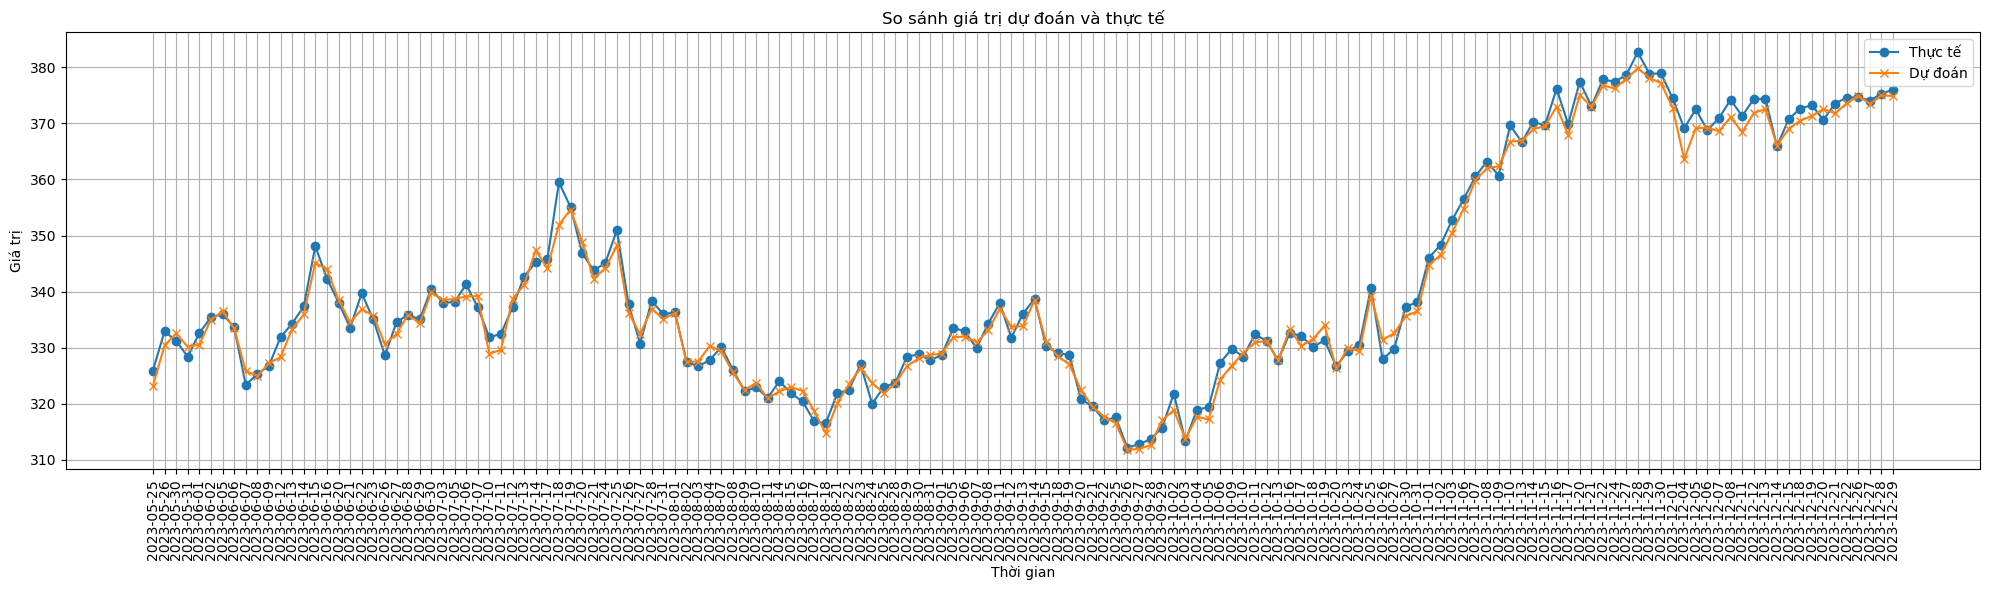

In [32]:
import matplotlib.pyplot as plt
time=average_values['year-month-day'].iloc[-len(validate_out):]

plt.figure(figsize=(20, 6))
plt.plot(time,validate_out , label='Thực tế', marker='o')
plt.plot(time, np.array(predict).reshape(-1, 1), label='Dự đoán', marker='x')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị dự đoán và thực tế')
plt.xticks(rotation=90)  # Xoay nhãn trục x để dễ đọc
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(val_real,np.array(predict).reshape(-1, 1))
print("----đánh giá mô hình----")
print("MAE: %.5f" %mae(np.array(predict).reshape(-1, 1),val_real))
print("MSE: %.5f" %mse(np.array(predict).reshape(-1, 1),val_real))
print("NSE: %.5f" %(1-(np.sum((val_real-np.array(predict).reshape(-1, 1))**2)/np.sum((val_real-np.mean(val_real))**2))))
print("R2: %.5f " %r2_score(val_real,np.array(predict).reshape(-1, 1)))
mape = mean_absolute_percentage_error(val_real,np.array(predict).reshape(-1, 1))
print("mape:",mape)

----đánh giá mô hình----
MAE: 1.47759
MSE: 3.36402
NSE: 0.99123
R2: 0.99123 
mape: 0.0043074886768765565
